In [1]:
!pip install neattext gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.0 MB/s eta 0:00:00


### Project flow:
1. Data Acquisition
2. Data Splitting: The dataset for the emotion detection project underwent division into training, testing, and validation sets.
2. Data visualization: Utilizing the seaborn library for data visualization to gain insights into the different sentiment levels within the dataset.
3. Data Preprocessing: Various preprocessing techniques were applied using the neattext library in the Natural Language Processing project. The preprocessing techniques include:

  + Data normalization
  + Removal of HTML tags from text
  + Removal of emails from text
  + Conversion of text to lowercase

5. Utilized the Gensim API package in Python to generate a weighted matrix during the model building phase, facilitating the extraction of semantic information from texts.
6. Model building using different RNN techniques such as LSTM, GRU, and CUDNN
7. Performing model evaluation to identify the best-performing model.
8. Evaluating the predictive performance of the model.







In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import gensim.downloader as gendownload
from tensorflow.keras.optimizers import Optimizer
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
from sklearn.metrics import classification_report

In [3]:
#reading in the data
train_data = pd.read_csv('/content/train.txt', names=['Input', 'Sentiment'],
                         sep=';', encoding='utf-8' )
test_data = pd.read_csv('/content/test.txt', names=['Input', 'Sentiment'],
                        sep=';', encoding='utf-8')
validation_data = pd.read_csv('/content/val.txt', names=['Input', 'Sentiment'],
                              sep=';', encoding='utf-8')

In [4]:
train_data.head(10)

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [5]:
#Available sentiments
train_data['Sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [6]:
train_data['Sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Sentiment, dtype: int64

In [7]:
#function to get the shapes of the train, test and validation dataset
def dataset_shapes(data1, data2, data3):
    training_data_shape = data1.shape
    testing_data_shape = data2.shape
    validation_data_shape = data3.shape

    return f'train_data_shape : {training_data_shape}', f'test_data_shape : {testing_data_shape}', f'validation_data_shape : {validation_data.shape}'


In [8]:
#calling the function
dataset_shapes(train_data, test_data, validation_data)

('train_data_shape : (16000, 2)',
 'test_data_shape : (2000, 2)',
 'validation_data_shape : (2000, 2)')

<Axes: xlabel='Sentiment', ylabel='count'>

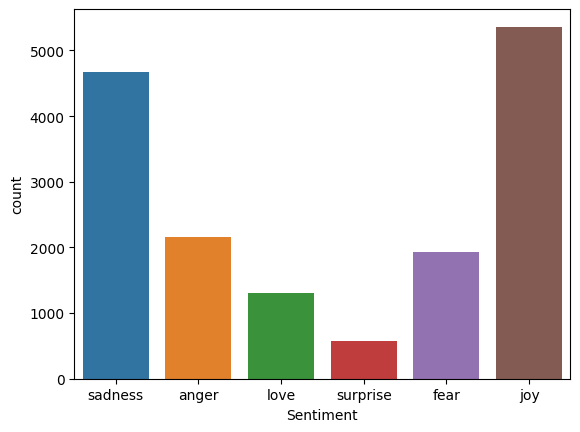

In [9]:
#A graphical illustration showcasing the various sentiment levels in the training_dataset
sns.countplot(x=train_data['Sentiment'])

In [10]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [11]:
#data preprocessing using neattext module
'''

  Convertion of texts to lower cases
  Removing stopwords
  Remove emails
  Elimate handles and urls
  Tokenization of strings into words
  Text norminalization to reduce randomness
'''

'\n\n  Convertion of texts to lower cases\n  Removing stopwords\n  Remove emails\n  Elimate handles and urls\n  Tokenization of strings into words\n  Text norminalization to reduce randomness\n'

In [12]:
def text_preprocessing(df, colname=''):
  col = colname
  #converting all texts in the dataset to lowercase
  df[col] = df[col].apply(lambda x: str(x).lower())
  #cleaning_text
  df[col] = df[col].apply(lambda x: nfx.clean_text(x))
  #norminalization of text
  df[col] = df[col].apply(lambda x: nfx.normalize(x))
  #Eliminating emails
  df[col] = df[col].apply(lambda x: nfx.remove_emails(x))
  #Remove htmltags
  df[col] = df[col].apply(lambda x: nfx.remove_html_tags(x))
  #Remove urls
  df[col] = df[col].apply(lambda x: nfx.remove_urls(x))

  return df

In [13]:
#cleaned text
cleaned_train_data = text_preprocessing(train_data, 'Input')
cleaned_train_data.sample(3)

,Input,Sentiment
8006,im feeling im watching reading beware spoilers...,love
7021,hate feeling like im strong,joy
9984,feel blessed god chosen help guide,love


In [14]:
# converting to categorical labels
le = LabelEncoder()
cleaned_train_data['Sentiment'] = le.fit_transform(cleaned_train_data['Sentiment'])
cleaned_train_data['Sentiment'].unique()

# test data
test_data['Sentiment'] = le.fit_transform(test_data['Sentiment'])
test_data['Sentiment'].unique()

#validation data
validation_data['Sentiment'] = le.fit_transform(validation_data['Sentiment'])
validation_data['Sentiment'].unique()

array([4, 3, 0, 2, 1, 5])

In [15]:
train_test_Input_data = pd.concat([cleaned_train_data['Input'], test_data['Input']], axis=0)
train_test_Input_data[0:51]

0                                 didnt feel humiliated
1           feeling hopeless damned hopeful cares awake
2             im grabbing minute post feel greedy wrong
3             feeling nostalgic fireplace know property
4                                       feeling grouchy
5         ive feeling little burdened lately wasnt sure
6     ive taking milligrams times recommended ive fa...
7        feel confused life teenager jaded year old man
8     petronas years feel petronas performed huge pr...
9                                         feel romantic
10                      feel like suffering seeing mean
11    feel running divine experience expect type spi...
12            think easiest time year feel dissatisfied
13                              feel low energy thirsty
14    immense sympathy general point possible proto ...
15                               feel reassured anxiety
16                               didnt feel embarrassed
17                            feel pretty pathet

In [16]:
#Instatiating the tokenizer class to vectorize the sentences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_test_Input_data)
#getting the word embeddings of the train and test input data
word_index = dict(itertools.islice(tokenizer.word_index.items(), 10))
word_index

{'feel': 1,
 'feeling': 2,
 'like': 3,
 'i': 4,
 'im': 5,
 'and': 6,
 'to': 7,
 'the': 8,
 'know': 9,
 'time': 10}

In [17]:
total_num_words = len(tokenizer.word_index)
total_num_words

16151

In [18]:
#creating the x_train, x_test, and x_validation variables

#x_train
X_train = tokenizer.texts_to_sequences(cleaned_train_data['Input'])
X_train_padded = pad_sequences(X_train, maxlen=300, padding='post')

#x_test
X_test = tokenizer.texts_to_sequences(test_data['Input'])
X_test_padded = pad_sequences(X_test, maxlen=300, padding='post')

#x_validation
X_validation = tokenizer.texts_to_sequences(validation_data['Input'])
X_validation_padded = pad_sequences(X_validation, maxlen=300, padding='post')


In [19]:
X_train_padded.shape[1]

300

In [20]:
''' creating the y_train, y_test and y_validation
 variables using the to_categorical function in tensorflow '''
y_train = to_categorical(y=cleaned_train_data['Sentiment'].values)
y_test = to_categorical(y=test_data['Sentiment'].values)
y_validation = to_categorical(y=validation_data['Sentiment'].values)

In [21]:
#creating weighted matrix using gensim-word2vec
#downloading gigawords of 100dimensions
wv = gendownload.load('glove-wiki-gigaword-100')


[==================================================] 100.0% 128.1/128.1MB downloaded


In [22]:
type(wv)

gensim.models.keyedvectors.KeyedVectors

In [23]:
wv['cat'].shape[0]

100

In [24]:
#creating a word2vec shape matrix
vector_size = 100
gensim_weight_matrix = np.zeros((total_num_words, vector_size))
gensim_weight_matrix.shape


(16151, 100)

In [25]:
for word, index in tokenizer.word_index.items():
    if index < total_num_words: # since index starts with zero
        if word in wv.index_to_key:
            gensim_weight_matrix[index] = wv[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [26]:
gensim_weight_matrix.shape

(16151, 100)

In [27]:
#building the model
embedding_dim = 100
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=total_num_words,
                              output_dim=embedding_dim, input_length=X_train_padded.shape[1],
                              weights=[gensim_weight_matrix]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #adding the dropout feature to prevent overfitting in the model
    tf.keras.layers.Dropout(0.2),
    #adding another Bidirectional lstm layer to the model
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')

])

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [29]:
#early stopping
class Early_stopping(tf.keras.callbacks.Callback):
  def on_epochs_end(self, epochs, logs={}):
    if logs.get('accuracy') is not None and logs.get('accuracy') <= 0.98:
      print('Model has an accuracy score of {}, terminating!!!!'.format(logs.get('accuracy')))
      self.model.stop_training = True

callback = Early_stopping()

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1615100   
                                                                 
 bidirectional (Bidirection  (None, 300, 256)          234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 300, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [31]:
history = model.fit(x=X_train_padded, y= y_train,
                    epochs=25,
                    steps_per_epoch=50, batch_size=120,
                    validation_data=(X_validation_padded, y_validation),
                    callbacks=callback)


Epoch 1/25
50/50 [==============================] - 26s 253ms/step - loss: 1.4673 - accuracy: 0.4312 - val_loss: 1.3481 - val_accuracy: 0.4915
Epoch 2/25
50/50 [==============================] - 7s 146ms/step - loss: 1.0347 - accuracy: 0.6170 - val_loss: 1.1432 - val_accuracy: 0.5825
Epoch 3/25
50/50 [==============================] - 8s 159ms/step - loss: 0.7214 - accuracy: 0.7446 - val_loss: 0.9518 - val_accuracy: 0.6810
Epoch 4/25
50/50 [==============================] - 6s 113ms/step - loss: 0.4519 - accuracy: 0.8325 - val_loss: 0.7125 - val_accuracy: 0.7375
Epoch 5/25
50/50 [==============================] - 5s 106ms/step - loss: 0.3438 - accuracy: 0.8720 - val_loss: 0.4779 - val_accuracy: 0.8320
Epoch 6/25
50/50 [==============================] - 5s 101ms/step - loss: 0.2524 - accuracy: 0.9049 - val_loss: 0.4007 - val_accuracy: 0.8485
Epoch 7/25
50/50 [==============================] - 5s 110ms/step - loss: 0.1987 - accuracy: 0.9227 - val_loss: 0.4852 - val_accuracy: 0.8340
Epoch

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
def model_performance(history, train_accuracy, val_accuracy):
  train_score = history.history[train_accuracy]
  validation_score = history.history[val_accuracy]

  print("The model's accuracy score on the training data is {}".format(round(train_score[-1], 2)))
  print("The model's accuracy score on the validation data is {}".format(round(validation_score[-1], 2)))


In [34]:
model_performance(history, 'accuracy', 'val_accuracy')

The model's accuracy score on the training data is 0.98
The model's accuracy score on the validation data is 0.89


<Figure size 640x480 with 0 Axes>

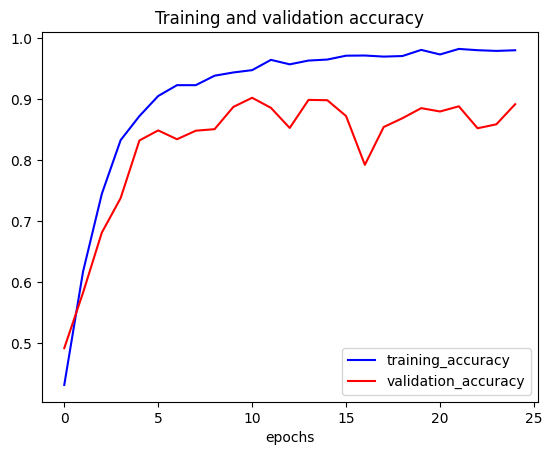

<Figure size 640x480 with 0 Axes>

In [35]:
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(train_accuracy))
# print(epochs)

plt.title("Training and validation accuracy")
plt.plot(epochs, train_accuracy, 'b', label='training_accuracy')
plt.plot(epochs, validation_accuracy, "r", label="validation_accuracy")
plt.xlabel('epochs')
plt.legend(loc=0)
plt.figure()


In [36]:
#Building the model using Gated Recurrent units(GRU)
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=total_num_words,
                              output_dim=embedding_dim, input_length=X_train_padded.shape[1],
                              weights=[gensim_weight_matrix]),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')

])

In [37]:
model2.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [38]:
history_model2 = model2.fit(x=X_train_padded, y= y_train,
                    epochs=25,
                    steps_per_epoch=50, batch_size=120,
                    validation_data=(X_validation_padded, y_validation),
                    callbacks=callback)

Epoch 1/25
50/50 [==============================] - 17s 187ms/step - loss: 1.4426 - accuracy: 0.4583 - val_loss: 1.4635 - val_accuracy: 0.4585
Epoch 2/25
50/50 [==============================] - 6s 124ms/step - loss: 0.9942 - accuracy: 0.6418 - val_loss: 0.8443 - val_accuracy: 0.7175
Epoch 3/25
50/50 [==============================] - 6s 113ms/step - loss: 0.5308 - accuracy: 0.8150 - val_loss: 0.4831 - val_accuracy: 0.8240
Epoch 4/25
50/50 [==============================] - 5s 105ms/step - loss: 0.2954 - accuracy: 0.8917 - val_loss: 0.3800 - val_accuracy: 0.8595
Epoch 5/25
50/50 [==============================] - 4s 86ms/step - loss: 0.2339 - accuracy: 0.9108 - val_loss: 0.2877 - val_accuracy: 0.9030
Epoch 6/25
50/50 [==============================] - 5s 103ms/step - loss: 0.1736 - accuracy: 0.9296 - val_loss: 0.2252 - val_accuracy: 0.9195
Epoch 7/25
50/50 [==============================] - 4s 84ms/step - loss: 0.1367 - accuracy: 0.9410 - val_loss: 0.2431 - val_accuracy: 0.9075
Epoch 8

In [39]:
model_performance(history_model2, 'accuracy', 'val_accuracy')

The model's accuracy score on the training data is 0.98
The model's accuracy score on the validation data is 0.92


<Figure size 640x480 with 0 Axes>

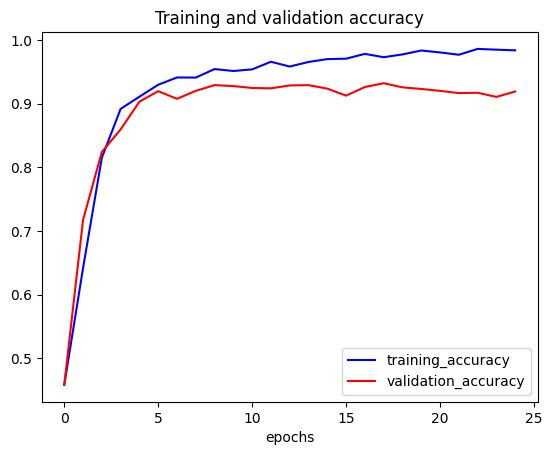

<Figure size 640x480 with 0 Axes>

In [40]:
train_accuracy = history_model2.history['accuracy']
validation_accuracy = history_model2.history['val_accuracy']
epochs = range(len(train_accuracy))
# print(epochs)

plt.title("Training and validation accuracy")
plt.plot(epochs, train_accuracy, 'b', label='training_accuracy')
plt.plot(epochs, validation_accuracy, "r", label="validation_accuracy")
plt.xlabel('epochs')
plt.legend(loc=0)
plt.figure()


In [41]:
#Training the model using cuDNN (Nvidia CUDA Deep Neural networks)
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim = total_num_words,# the whole vocabulary size
                          output_dim = embedding_dim, # vector space dimension
                          input_length= X_train_padded.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(CuDNNLSTM(100,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(CuDNNLSTM(200,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(CuDNNLSTM(100,return_sequences=False)),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

In [42]:
model3.compile(loss='categorical_crossentropy',
               optimizer='adam', metrics=['accuracy'])

In [43]:
history_model3 = model3.fit(x=X_train_padded, y= y_train,
                    epochs=25,
                    steps_per_epoch=50, batch_size=120,
                    validation_data=(X_validation_padded, y_validation),
                    callbacks=callback)

Epoch 1/25
50/50 [==============================] - 17s 207ms/step - loss: 1.4484 - accuracy: 0.4428 - val_loss: 1.3724 - val_accuracy: 0.4845
Epoch 2/25
50/50 [==============================] - 9s 191ms/step - loss: 1.2110 - accuracy: 0.5533 - val_loss: 1.4295 - val_accuracy: 0.4490
Epoch 3/25
50/50 [==============================] - 9s 188ms/step - loss: 1.0921 - accuracy: 0.5922 - val_loss: 1.1415 - val_accuracy: 0.5760
Epoch 4/25
50/50 [==============================] - 9s 184ms/step - loss: 0.9514 - accuracy: 0.6540 - val_loss: 1.0600 - val_accuracy: 0.5950
Epoch 5/25
50/50 [==============================] - 9s 183ms/step - loss: 0.8562 - accuracy: 0.6885 - val_loss: 0.9760 - val_accuracy: 0.6360
Epoch 6/25
50/50 [==============================] - 9s 187ms/step - loss: 0.7301 - accuracy: 0.7312 - val_loss: 0.8130 - val_accuracy: 0.7120
Epoch 7/25
50/50 [==============================] - 9s 183ms/step - loss: 0.6555 - accuracy: 0.7555 - val_loss: 0.6305 - val_accuracy: 0.7735
Epoch

<Figure size 640x480 with 0 Axes>

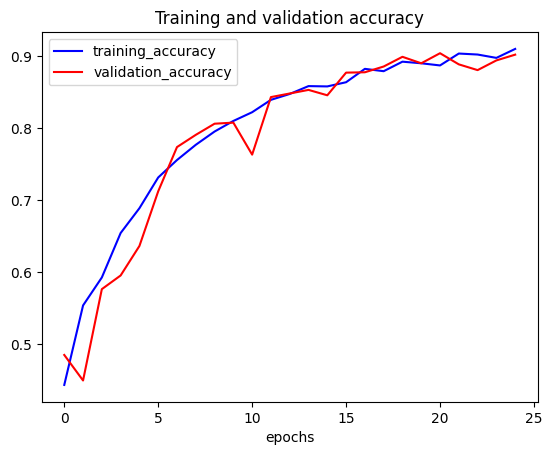

<Figure size 640x480 with 0 Axes>

In [44]:
train_accuracy = history_model3.history['accuracy']
validation_accuracy = history_model3.history['val_accuracy']
epochs = range(len(train_accuracy))
# print(epochs)

plt.title("Training and validation accuracy")
plt.plot(epochs, train_accuracy, 'b', label='training_accuracy')
plt.plot(epochs, validation_accuracy, "r", label="validation_accuracy")
plt.xlabel('epochs')
plt.legend(loc=0)
plt.figure()


In [45]:
#checking model's performance for the cuDNN model
model_performance(history_model3, 'accuracy', 'val_accuracy')

The model's accuracy score on the training data is 0.91
The model's accuracy score on the validation data is 0.9


In [46]:
y_pred =   np.argmax(model.predict(X_test_padded), axis  =  1)
y_pred

63/63 [==============================] - 2s 18ms/step


array([4, 4, 4, ..., 2, 2, 5])

In [47]:
y_true = np.argmax(y_test, axis=1)
y_true

array([4, 4, 4, ..., 2, 2, 1])

In [48]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       275
           1       0.95      0.71      0.81       224
           2       0.95      0.84      0.90       695
           3       0.68      0.93      0.79       159
           4       0.91      0.93      0.92       581
           5       0.60      0.82      0.69        66

    accuracy                           0.87      2000
   macro avg       0.82      0.86      0.83      2000
weighted avg       0.89      0.87      0.87      2000



In [49]:
#testing the model
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if val==value:
            return key

In [71]:
def testing_model(sentence):
  sentence_to_list = []
  sentence_to_list.append(sentence)
  # tokenizer = Tokenizer()
  # tokenizer.fit_on_texts(sentence_to_list)
  sentence_sequences = tokenizer.texts_to_sequences(sentence_to_list)
  sentence_padded = pad_sequences(sentence_sequences, maxlen=300, padding='post')
  predicted = model3.predict(sentence_padded)
  print(predicted)
  predicted_sentiment = get_key(np.max(np.argmin(predicted, axis=-1)))
  print("the predicted sentiment is {}".format(predicted_sentiment))

  # print("the predicted sentiment is", predicted_sentiment)




In [72]:
# testing_model(str(input('sentence: ')))
testing_model(input(str('sentence:')))

sentence:Are you for real?
1/1 [==============================] - 0s 19ms/step
[[0.17931779 0.15379134 0.43620938 0.02578877 0.19490871 0.00998407]]
the predicted sentiment is surprise


In [74]:
# testing_model(str(input('sentence: ')))
testing_model(input(str('sentence:')))

sentence:i just got robbed at the station
1/1 [==============================] - 0s 28ms/step
[[0.06827433 0.7729668  0.08997146 0.00226501 0.06158963 0.00493276]]
the predicted sentiment is sadness


> Obervation:

The visualization above depict a consistent upward trend in the pattern between training and validation accuracy. This suggests that there is no evidence of overfitting in the model. Overfitting concerns have been addressed by implementing dropout mechanisms in the neural networks, effectively removing random neurons from the fully connected layers.

In [70]:
import pickle
#saving the model
with open('model.pkl', 'wb') as f:
  pickle.dump(history_model3, f)